In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import ConcatDataset
import torchmetrics as tm
import os


In [3]:
def new_model(name, device):
    if name == "ResNet":
       model = models.resnet18(pretrained=True)
    elif name == "DenseNet":
       print('densenet')
       model = models.densenet201(weights='DEFAULT')
    else:
       model = models.resnext101_64x4d(weights='DEFAULT')

    for param in model.parameters():
        param.requires_grad = True
    
    if hasattr(model, 'fc'):
      # for param in model.fc.parameters():
      #   param.requires_grad = True
      num_features = model.fc.in_features
      model.fc = nn.Linear(num_features, len(class_names)) # Set the final layer to have 7 output classes
    elif hasattr(model, 'classifier'):
      # for param in model.classifier.parameters():
      #   param.requires_grad = True
      num_features = model.classifier.in_features
      model.classifier = nn.Linear(num_features, len(class_names))
        
    model = model.to(device)
    model.name = name

    return model

In [4]:
# Define data transformations for data augmentation and normalization
train_transforms = [
        transforms.Resize(size=(180,180)),
        transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)
        # transforms.RandomRotation(degrees=60),
        #transforms.RandomGrayscale(),
        #transforms.RandomHorizontalFlip(),
    ]
grayscale_transforms = train_transforms.copy()
grayscale_transforms.append(transforms.Grayscale(num_output_channels=3))
train_transforms_end = [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
data_transforms = {
    'train': transforms.Compose(train_transforms+train_transforms_end),
    'val': transforms.Compose([
        transforms.Resize(size=(180,180)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_transforms_flipped = {
    'train': transforms.Compose(train_transforms+[transforms.RandomHorizontalFlip(p=1)]+train_transforms_end),
    'val': transforms.Compose([
        transforms.Resize(size=(180,180)),
        transforms.RandomHorizontalFlip(p=1),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [5]:
# Define the data directory
ROOT_DIR = os.path.abspath(os.curdir)
print(ROOT_DIR)
dataset_name='dataset3'
data_dir = os.path.join(ROOT_DIR, dataset_name)
print(data_dir)

concatdatasets = []
concatdatasets_val = []
# Create data loaders
#og_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms.Compose(train_transforms_end)) for x in ['train']}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
tr_flipped_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_flipped[x]) for x in ['train','val']}
tr_grayscale_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms.Compose(grayscale_transforms+train_transforms_end)) for x in ['train','val']}
grayscale_transforms.append(transforms.RandomHorizontalFlip(p=1))
tr_grayscale_flipped_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms.Compose(grayscale_transforms+train_transforms_end)) for x in ['train','val']}

#concatdatasets.append(og_image_datasets['train'])
concatdatasets.append(image_datasets['train'])
concatdatasets.append(tr_flipped_dataset['train'])
concatdatasets.append(tr_grayscale_dataset['train'])
concatdatasets.append(tr_grayscale_flipped_dataset['train'])

concatdatasets_val.append(image_datasets['val'])
concatdatasets.append(tr_flipped_dataset['val'])
concatdatasets_val.append(tr_grayscale_dataset['val'])
concatdatasets_val.append(tr_grayscale_flipped_dataset['val'])

r_times = 5;
rotate_transf = train_transforms
tr_rotate = []
print(rotate_transf)
for i in range(5):
    rotate_transf = train_transforms.copy()
    for j in range(i):
         rotate_transf.append(transforms.RandomRotation(degrees=(60,60)))
    concatdatasets.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms.Compose(rotate_transf+train_transforms_end)))
    concatdatasets_val.append(datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms.Compose(rotate_transf+train_transforms_end)))

image_datasets['train'] = ConcatDataset(concatdatasets)
image_datasets['val'] = ConcatDataset(concatdatasets_val)
print(len(image_datasets['train']))
print(len(image_datasets['val']))


# print(image_datasets['train'][0])
#transforms.functional.adjust_saturation(image_datasets, saturation_factor=0.3),
#v2.functional.adjust_hue(image_datasets,hue_factor=0.3),
#image_datasets

/home/lemawul/PyTorch
/home/lemawul/PyTorch/dataset3
[Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True), ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))]
3649
392


In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].datasets[0].classes
class_names

#print(dataloaders['train'])

{'train': 3649, 'val': 392}


['Circle', 'Cross', 'Goat', 'Person', 'Spiral', 'Stag', 'Zigzag']

In [7]:
if hasattr(image_datasets['train'].datasets[0], 'class_to_idx'):
    class_to_idx = image_datasets['train'].datasets[0].class_to_idx
    print("Class to index mapping:", class_to_idx)

Class to index mapping: {'Circle': 0, 'Cross': 1, 'Goat': 2, 'Person': 3, 'Spiral': 4, 'Stag': 5, 'Zigzag': 6}


In [8]:
def count_images_in_dataset(dataset_path):
    """
    Counts the number of .jpg images in each class folder for train and val directories.
    
    Args:
        dataset_path (str): Path to the dataset directory.
    
    Returns:
        dict: A dictionary containing counts of images for each class in train and val.
    """
    counts = {}
    
    # Iterate through 'train' and 'val' folders
    for split in ['train', 'val']:
        split_path = os.path.join(dataset_path, split)
        class_counts = {}
        
        # Check if the split folder exists
        if os.path.exists(split_path):
            # Iterate through class folders
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                
                if os.path.isdir(class_path):
                    # Count the number of .jpg files in the class folder
                    num_images = len([f for f in os.listdir(class_path) if f.endswith('.jpg') and os.path.isfile(os.path.join(class_path, f))])
                    class_counts[class_name] = num_images
        else:
            print(f"Directory '{split_path}' does not exist!")
        
        counts[split] = class_counts
    
    return counts

# Path to your dataset directory
dataset_path = data_dir

# Count images
image_counts = count_images_in_dataset(dataset_path)

# Print the results
for split, class_counts in image_counts.items():
    print(f"{split}:")
    total = 0
    for class_name, count in class_counts.items():
        total = total + count
        print(f"  {class_name}: {count} images")
    print(f"Total:{total}")

train:
  Stag: 25 images
  Zigzag: 37 images
  Person: 118 images
  Circle: 75 images
  Spiral: 51 images
  Goat: 76 images
  Cross: 17 images
Total:399
val:
  Stag: 3 images
  Zigzag: 7 images
  Person: 16 images
  Circle: 9 images
  Spiral: 6 images
  Goat: 6 images
  Cross: 2 images
Total:49


In [34]:
# Load the pre-trained ResNet-18 model   
# model_resnet = models.resnet18(pretrained=True)
model_resnet = "ResNet"
# model_dense = models.densenet201(weights='DEFAULT')
model_dense = "DenseNet"
# model_resnext = models.resnext101_64x4d(weights='DEFAULT')
model_resnext = "ResNext"
models_list = []

models_list.append(model_resnet)
models_list.append(model_dense)
models_list.append(model_resnext)


for m in models_list:
    print(m)
      

# num_features = model.fc.in_features
# num_features_class = model.classifier.in_features

# model.fc = nn.Linear(num_features, len(class_names))  # Set the final layer to have 8 output classes
#model.classifier = nn.Linear(num_features, len(class_names))  # Set the final layer to have 8 output classes
# Freeze all layers except the final classification layer
# for name, param in model.named_parameters():
#     if "fc" in name:  # Unfreeze the final classification layer
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001*2.82, momentum=0.9)  # Use all parameters, do lr = 004 if batches are 64 sqrt(64/4)


# Move the model to the GPU if available


ResNet
DenseNet
ResNext


In [35]:
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

In [36]:
def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [37]:
# Training loop
import torchmetrics as tm

def train_models(models, dataloaders, dataset_sizes, class_names, dataset_name, device, run_no, num_epochs=100):
    """
    Train an array of models and log their performance.

    Args:
        models (list of dict): List of dictionaries, each containing a 'model', 'optimizer', and optional 'checkpoint_path'.
        dataloaders (dict): A dictionary containing 'train' and 'val' DataLoader objects.
        dataset_sizes (dict): A dictionary containing sizes of the training and validation datasets.
        class_names (list): List of class names.
        dataset_name (str): Name of the dataset for logging.
        device (torch.device): Device to use for training (e.g., 'cuda' or 'cpu').
        num_epochs (int): Number of epochs to train each model. Default is 300.

    Returns:
        None
    """
    for model_info in models:
        model = new_model(model_info, device)
        optimizer = optim.SGD(model.parameters(), lr=0.001*2.82, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        print(f"MODEL {model.name}")
        
        # Initialize metrics
        f1_metric = tm.F1Score(task='multiclass', num_classes=len(class_names), average='none').to(device)
        recall_metric = tm.Recall(task='multiclass', num_classes=len(class_names), average='none').to(device)

        # Skip if model already trained
        model_string = f'{dataset_name}_model_new_{model.name}_{num_epochs}e_r{run_no}.pth'
        if os.path.isfile(model_string):
            print(f'Skipping, already trained {model_string}.')
            continue

        # Load checkpoint if available
        checkpoint_epoch = 0
        checkpoint_path = f'{dataset_name}_{model.name}_checkpoint.pth'
        if os.path.isfile(checkpoint_path):
            model, optimizer, checkpoint_epoch = load_checkpoint(model, optimizer, checkpoint_path)

        # Setup TensorBoard writer
        writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model.name}_run_{run_no}")

        for epoch in range(checkpoint_epoch, num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Reset metrics
                f1_metric.reset()
                recall_metric.reset()

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Update metrics
                    f1_metric.update(preds, labels)
                    recall_metric.update(preds, labels)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_f1 = f1_metric.compute()
                epoch_recall = recall_metric.compute()

                # Log metrics
                writer.add_scalar(f"{phase}_Loss", epoch_loss, epoch)
                writer.add_scalar(f"{phase}_Accuracy", epoch_acc, epoch)
                for class_name, f1, recall in zip(class_names, epoch_f1, epoch_recall):
                    writer.add_scalar(f"{phase}_F1Score_Class_{class_name}", f1, epoch)
                    writer.add_scalar(f"{phase}_Recall_Class_{class_name}", recall, epoch)
                
                avg_epoch_f1 = epoch_f1.mean()
                avg_epoch_recall = epoch_recall.mean()
                writer.add_scalar(f"{phase}_F1Score_Avg", avg_epoch_f1, epoch)
                writer.add_scalar(f"{phase}_Recall_Avg", avg_epoch_recall, epoch)

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1 Avg: {avg_epoch_f1:.4f} Recall Avg: {avg_epoch_recall:.4f}")

            # Save checkpoint after each epoch
            if checkpoint_path:
                save_checkpoint(model, optimizer, checkpoint_path, epoch)
        
        ## # Save the model
        torch.save(model.state_dict(), model_string)
        
        writer.flush()
        writer.close()

        if os.path.exists(checkpoint_path):
          os.remove(checkpoint_path)
    print("Training complete for all models!")

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
for run in range(5):
    print(f"RUN {run}")
    train_models(models_list, dataloaders, dataset_sizes, class_names, dataset_name, device, run, 100)

RUN 0
MODEL ResNet
train Loss: 0.2519 Acc: 0.8877 F1 Avg: 0.8852 Recall Avg: 0.8855
val Loss: 0.3781 Acc: 0.8548 F1 Avg: 0.8524 Recall Avg: 0.8516
train Loss: 0.0940 Acc: 0.9667 F1 Avg: 0.9660 Recall Avg: 0.9667
val Loss: 0.4898 Acc: 0.8306 F1 Avg: 0.8302 Recall Avg: 0.8331
train Loss: 0.0476 Acc: 0.9812 F1 Avg: 0.9808 Recall Avg: 0.9811
val Loss: 0.5423 Acc: 0.8347 F1 Avg: 0.8313 Recall Avg: 0.8310
train Loss: 0.0324 Acc: 0.9872 F1 Avg: 0.9869 Recall Avg: 0.9871
val Loss: 0.2833 Acc: 0.8871 F1 Avg: 0.8871 Recall Avg: 0.8878
train Loss: 0.0285 Acc: 0.9899 F1 Avg: 0.9896 Recall Avg: 0.9897
val Loss: 0.3305 Acc: 0.8871 F1 Avg: 0.8862 Recall Avg: 0.8852
train Loss: 0.0194 Acc: 0.9932 F1 Avg: 0.9930 Recall Avg: 0.9930
val Loss: 0.3510 Acc: 0.9032 F1 Avg: 0.9026 Recall Avg: 0.9016
train Loss: 0.0219 Acc: 0.9929 F1 Avg: 0.9927 Recall Avg: 0.9929
val Loss: 0.3284 Acc: 0.8911 F1 Avg: 0.8903 Recall Avg: 0.8893
train Loss: 0.0153 Acc: 0.9944 F1 Avg: 0.9943 Recall Avg: 0.9944
val Loss: 0.3732 Acc

KeyboardInterrupt: 

# Save older variant of model for PATE

In [9]:
import torch
import torch.nn as nn
import os
from torchvision import models, transforms
from PIL import Image

# Load the saved model
#model = models.resnet18(pretrained=True)
#model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model = models.densenet201(weights='DEFAULT')
#model = models.resnext101_64x4d(weights='DEFAULT')
#num_features = model.fc.in_features
num_features = model.classifier.in_features
#model.fc = nn.Linear(num_features, 2)
model.classifier = nn.Linear(num_features, 2)  # Set the final layer to have 8 output classes
model.to('cpu')
model_name = 'dataset3_GAN_Person+Circle+Spiral_model_new_DenseNet_100e_r0'
ROOT_DIR = os.path.abspath(os.curdir)
print(ROOT_DIR)
dataset_name='densenet_GAN_P+C'
data_dir = os.path.join(ROOT_DIR, dataset_name)
model_name = os.path.join(data_dir, model_name)
model.load_state_dict(torch.load(model_name+'.pth'))

model.eval()
torch.save(model.state_dict(), model_name+'_old.pth', _use_new_zipfile_serialization=False)

# # Create a new model with the correct final layer
# new_model = models.resnet18(pretrained=True)
# new_model.fc = nn.Linear(new_model.fc.in_features, 8)  # Adjust to match the desired output units

# # Copy the weights and biases from the loaded model to the new model
# new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
# new_model.fc.bias.data = model.fc.bias.data[0:2]


/home/lemawul/PyTorch


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [42]:
# Load and preprocess the unseen image
ROOT_DIR = os.path.abspath(os.curdir)
print(ROOT_DIR)
dataset_name = 'dataset'
phase_name = 'val'
class_dir = 'Person'
image_path = 'DSC_0239_Person_7.jpg'  # Replace with how your image is called

data_dir = os.path.join(ROOT_DIR, dataset_name, phase_name, class_dir, image_path)
image = Image.open(data_dir)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


/home/lemawul/ML


Perform inference using the model:

In [43]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)
#print(output)
# Get the predicted class
_, predicted_class = output.max(1)
#print(predicted_class.item())

# Map the predicted class to the class name
class_names = ['Circle', 'Cross',
               'Goat','Person','Spiral','Stag','Zigzag']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: Person


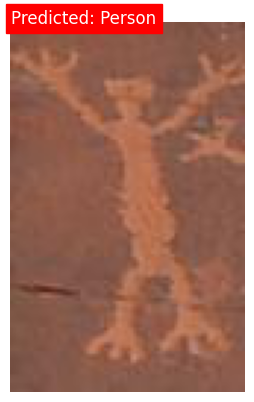

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(0, 0, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [8]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm

def process_dataset(dataset_path, output_path):
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Process both train and test folders
    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            continue
            
        print(f"Processing {split} set...")
        
        # Get all XML files in the folder
        xml_files = [f for f in os.listdir(split_path) if f.endswith('.xml')]
        
        for xml_file in tqdm(xml_files, desc=f"Processing {split} images"):
            # Parse XML file
            xml_path = os.path.join(split_path, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Get corresponding image file
            filename = root.find('filename').text
            image_path = os.path.join(split_path, filename)
            
            try:
                # Open image
                with Image.open(image_path) as img:
                    # Process each object in the XML
                    for obj in root.findall('object'):
                        label = obj.find('name').text
                        bndbox = obj.find('bndbox')
                        
                        # Get bounding box coordinates
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                        
                        # Crop the image
                        cropped_img = img.crop((xmin, ymin, xmax, ymax))
                        
                        # Create label directory if it doesn't exist
                        label_dir = os.path.join(output_path, split, label)
                        os.makedirs(label_dir, exist_ok=True)
                        
                        # Save cropped image
                        base_name = os.path.splitext(filename)[0]
                        output_filename = f"{base_name}_{xmin}_{ymin}_{xmax}_{ymax}.jpg"
                        output_path_full = os.path.join(label_dir, output_filename)
                        
                        cropped_img.save(output_path_full)
                        
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")

if __name__ == "__main__":
    # Set your paths here
    dataset_path = "bulgariaspain"  # Path to your dataset
    output_path = "cropped_bulgariaspain"  # Where to save cropped images
    
    process_dataset(dataset_path, output_path)
    print("Processing complete!")

Processing train set...


Processing train images: 100%|██████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.05it/s]


Processing test set...


Processing test images: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]

Error processing bulgariaspain/test/20190912_171259.jpg: cannot write empty image as JPEG
Processing complete!
